In [100]:
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [101]:
def preprocess(file, drop):
    df = pd.read_csv(file)
    df['Genetic_mutation_frame_type'] = (df['Genetic_mutation_frame_type'] == "Out of frame").astype(int)
    df_data = df.loc[:, ~df.columns.isin(drop)]
    df_features = df_data.columns.values
    return df, df_features

In [102]:
metrics, metrics_features = preprocess("csv/patients.csv", ["key", "individual", "CASE_ID", "Glucocorticoid_Use", "Disease_Type"])
exons, exons_features = preprocess("csv/affected_exons.csv", ["key", "Disease_Type"])
isoforms, isoforms_features = preprocess("csv/affected_isoforms.csv", ["key", "Disease_Type"])
tissues, tissues_features = preprocess("csv/patient_tpm.csv", ["key", "Disease_Type"])

UMAP

In [147]:
def project_umap(df, drop, title, output):
    reducer = umap.UMAP()
    scaled_metrics = StandardScaler().fit_transform(df.drop(drop, axis=1))
    embedding = reducer.fit_transform(scaled_metrics)
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[sns.color_palette()[x] for x in df.Disease_Type.map({"BMD": 0, "DMD": 1})],
        alpha=0.5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=24)
    plt.savefig(output, format='png',bbox_inches = "tight")
    plt.show()

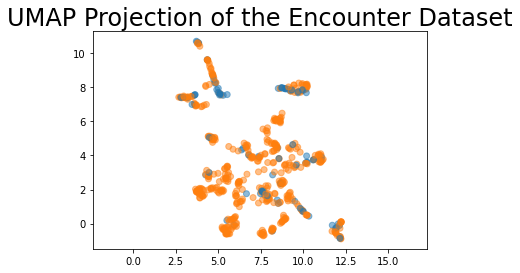

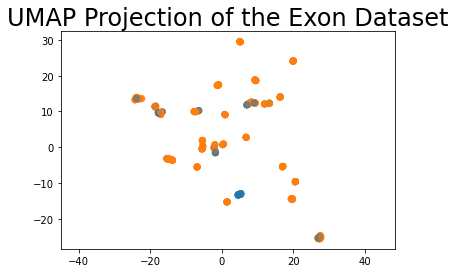

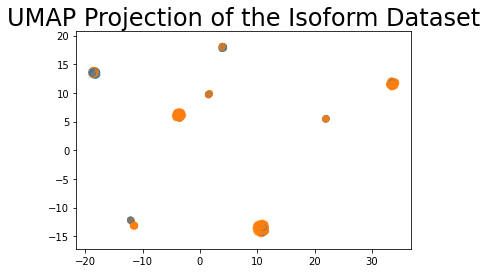

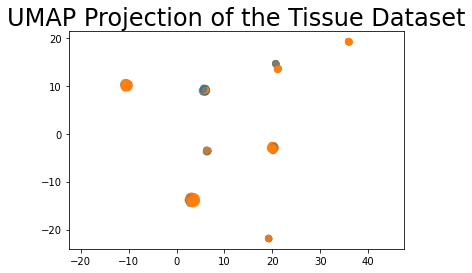

In [148]:
project_umap(metrics, ["key", "individual", "CASE_ID", "Glucocorticoid_Use", "Disease_Type"], "UMAP Projection of the Encounter Dataset", "img/png/metricsumap.png")
project_umap(exons, ["key", "Disease_Type"], "UMAP Projection of the Exon Dataset", "img/png/exonsumap.png")
project_umap(isoforms, ["key", "Disease_Type"], "UMAP Projection of the Isoform Dataset", "img/png/isoformsumap.png")
project_umap(tissues, ["key", "Disease_Type"], "UMAP Projection of the Tissue Dataset", "img/png/tissuesumap.png")

In [141]:
def scorer(X, y, model):
    cv = StratifiedKFold(shuffle=True)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    avg = np.mean(scores)
    return avg, scores

In [146]:
for predictor in [metrics, exons, isoforms, tissues]:
    try:
        X = predictor.drop(["key", "individual", "CASE_ID", "Glucocorticoid_Use", "Disease_Type"], axis=1)
    except KeyError:
        X = predictor.drop(["key", "Disease_Type"], axis=1)
    X = StandardScaler().fit_transform(X)
    y = predictor["Disease_Type"]
    for classifier in [SVC(), LogisticRegression(), tree.DecisionTreeClassifier(), RandomForestClassifier()]:
        print(scorer(X, y, classifier)[0])

0.4555232550041092
0.613853787590136
0.6274490047128369
0.6336477212831456
0.7556438032491493
0.7559659234051685
0.7683746806840229
0.7962889133666575
0.7433755444214049
0.7453414177643626
0.7499959930632656
0.45551293776810875
0.7656662459934278
0.7399476710737971
0.7441461151393549
0.5214244489462827


In [108]:
X = exons.drop(["key", "Disease_Type"], axis=1)
X = StandardScaler().fit_transform(X)
y = exons["Disease_Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y)

In [133]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[10  8]
 [ 2 93]]
              precision    recall  f1-score   support

         BMD       0.83      0.56      0.67        18
         DMD       0.92      0.98      0.95        95

    accuracy                           0.91       113
   macro avg       0.88      0.77      0.81       113
weighted avg       0.91      0.91      0.90       113



In [134]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[11  7]
 [ 9 86]]
              precision    recall  f1-score   support

         BMD       0.55      0.61      0.58        18
         DMD       0.92      0.91      0.91        95

    accuracy                           0.86       113
   macro avg       0.74      0.76      0.75       113
weighted avg       0.87      0.86      0.86       113



[[12  6]
 [ 6 89]]
              precision    recall  f1-score   support

         BMD       0.67      0.67      0.67        18
         DMD       0.94      0.94      0.94        95

    accuracy                           0.89       113
   macro avg       0.80      0.80      0.80       113
weighted avg       0.89      0.89      0.89       113

1                              0.000000
2                              0.000000
3                              0.011753
4                              0.006761
5                              0.011063
                                 ...   
76                             0.000000
77                             0.000000
78                             0.000000
79                             0.000000
Genetic_mutation_frame_type    0.463550
Length: 80, dtype: float64


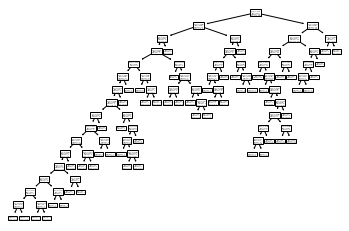

In [140]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
tree.plot_tree(dt)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
importances = pd.Series(dt.feature_importances_,index=exons_features)
print(importances)

[[11  7]
 [ 4 91]]
              precision    recall  f1-score   support

         BMD       0.73      0.61      0.67        18
         DMD       0.93      0.96      0.94        95

    accuracy                           0.90       113
   macro avg       0.83      0.78      0.80       113
weighted avg       0.90      0.90      0.90       113



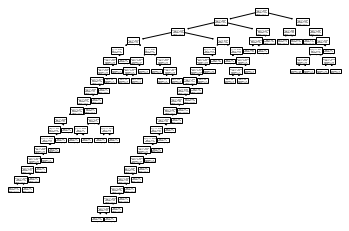

In [136]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
estimator = rf.estimators_[5]
plt.figure()
tree.plot_tree(estimator)
plt.savefig('img/svg/exonstree.svg',format='svg',bbox_inches = "tight")